## Predizendo o IBOV com GP-ARX

Realizar predições no mercado financeiro é um desafio encarado tanto pela indústria quanto pela academia. O aspecto altamente estocástico do problema é um verdadeiro desafio. Existem algumas abordagens para lidar com essa encrenca, alguns deles são: **ARCH**, **GARCH**, **Redes Neurais Recorrentes**, **Redes Neurais Convolucionais**, **ARIMA**, **Métodos Bayesianos** e, inclusive, combinações destes métodos (**Ensemble Learning**).

Neste trabalho vamos analisar o resultado de uma abordagem que utiliza um método Bayesiano e um método autoregressivo, o modelo **GP-ARX**.ARX significa *Autoregressive with Exogenous* e GP significa *Gaussian Process*. 

### ARX

### Processos Gaussianos

### Principais Referências

In [16]:
# Baixe os dados do IBOV usando a biblioteca yfinance
start_date = '2022-01-01'
end_date = '2023-01-01'
ibov_data = yf.download('^BVSP', start=start_date, end=end_date)['Adj Close']

# Remover NaNs resultantes dos lags
ibov_data = ibov_data.dropna()

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


/home/victor/.local/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Mean Squared Error (MSE) - ARX: 1422572.2484511218
Mean Squared Error (MSE) - GP-ARX: 1409274.9734863238


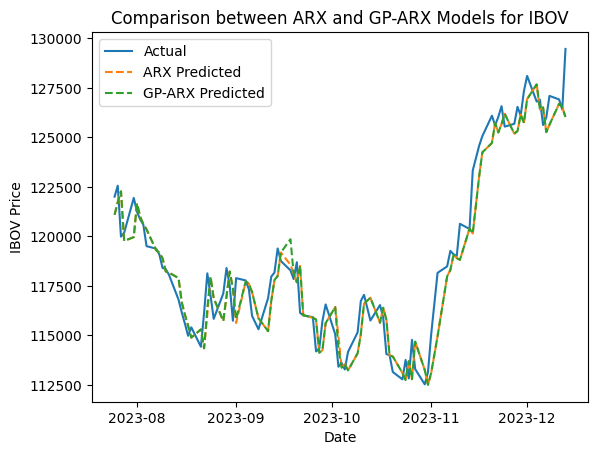

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.linear_model import LinearRegression
from datetime import datetime

# Baixe os dados do IBOV usando a biblioteca yfinance
start_date = '2022-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')
ibov_data = yf.download('^BVSP', start=start_date, end=end_date)['Adj Close']

# Criar um dataframe com lags do IBOV como variável exógena
data = pd.DataFrame({'IBOV': ibov_data, 'IBOV_Lag1': ibov_data.shift(1)})

# Remover NaNs resultantes dos lags
data = data.dropna()

# Dividir os dados em treinamento e teste
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Definir as variáveis dependentes e independentes
y_train, X_train = train['IBOV'], train[['IBOV_Lag1']]
y_test, X_test = test['IBOV'], test[['IBOV_Lag1']]

# Ajustar o modelo ARX
arx_model = LinearRegression()
arx_model.fit(X_train, y_train)
predictions_arx = arx_model.predict(X_test)

# Ajustar o modelo de processo gaussiano aos resíduos
residuals = y_train - arx_model.predict(X_train)
residuals = residuals.values.reshape(-1, 1)  # Reshape para um array 2D
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp_model.fit(X_train, residuals)

# Prever os resíduos nos dados de teste
residuals_pred, _ = gp_model.predict(X_test, return_std=True)

# Adicionar a previsão dos resíduos aos resultados do ARX
predictions_gparx = arx_model.predict(X_test) + residuals_pred.flatten()

# Avaliar o desempenho dos modelos (pode ser adaptado conforme necessário)
mse_arx = np.mean((predictions_arx - y_test)**2)
mse_gparx = np.mean((predictions_gparx - y_test)**2)

print(f'Mean Squared Error (MSE) - ARX: {mse_arx}')
print(f'Mean Squared Error (MSE) - GP-ARX: {mse_gparx}')

# Visualizar os resultados
import matplotlib.pyplot as plt

plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, predictions_arx, label='ARX Predicted', linestyle='--')
plt.plot(test.index, predictions_gparx, label='GP-ARX Predicted', linestyle='--')
plt.legend()
plt.xlabel('Date')
plt.ylabel('IBOV Price')
plt.title('Comparison between ARX and GP-ARX Models for IBOV')
plt.show()


[*********************100%%**********************]  1 of 1 completed


/home/victor/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/victor/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Mean Squared Error (MSE) - ARX: 9.604903312249552e-05
Mean Squared Error (MSE) - GP-ARX: 9.7398923245735e-05


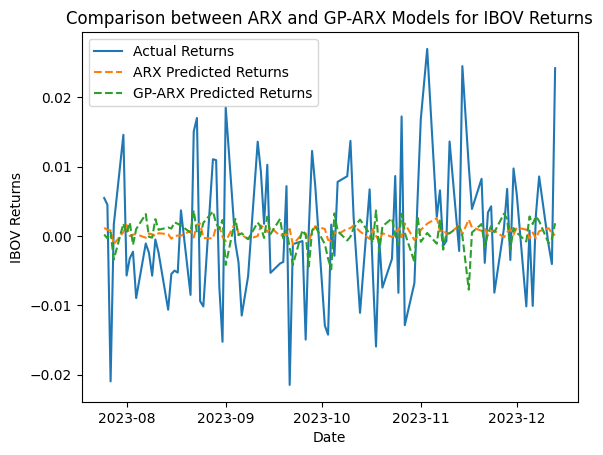

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.linear_model import LinearRegression
from datetime import datetime

# Baixe os dados do IBOV usando a biblioteca yfinance
start_date = '2022-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')
ibov_data = yf.download('^BVSP', start=start_date, end=end_date)['Adj Close']

# Calcular os retornos
ibov_returns = ibov_data.pct_change().dropna()

# Criar um dataframe com lags dos retornos do IBOV como variável exógena
data = pd.DataFrame({'IBOV_Returns': ibov_returns, 'IBOV_Returns_Lag1': ibov_returns.shift(1)})

# Remover NaNs resultantes dos lags
data = data.dropna()

# Dividir os dados em treinamento e teste
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Definir as variáveis dependentes e independentes
y_train, X_train = train['IBOV_Returns'], train[['IBOV_Returns_Lag1']]
y_test, X_test = test['IBOV_Returns'], test[['IBOV_Returns_Lag1']]

# Ajustar o modelo ARX
arx_model = LinearRegression()
arx_model.fit(X_train, y_train)
returns_predictions_arx = arx_model.predict(X_test)

# Ajustar o modelo de processo gaussiano aos resíduos
residuals = y_train - arx_model.predict(X_train)
residuals = residuals.values.reshape(-1, 1)  # Reshape para um array 2D
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp_model.fit(X_train, residuals)

# Prever os resíduos nos dados de teste
residuals_pred, _ = gp_model.predict(X_test, return_std=True)

# Adicionar a previsão dos resíduos aos resultados do ARX
returns_predictions_gparx = arx_model.predict(X_test) + residuals_pred.flatten()

# Avaliar o desempenho dos modelos (pode ser adaptado conforme necessário)
mse_arx = np.mean((returns_predictions_arx - y_test)**2)
mse_gparx = np.mean((returns_predictions_gparx - y_test)**2)

print(f'Mean Squared Error (MSE) - ARX: {mse_arx}')
print(f'Mean Squared Error (MSE) - GP-ARX: {mse_gparx}')

# Visualizar os resultados
import matplotlib.pyplot as plt

plt.plot(test.index, y_test, label='Actual Returns')
plt.plot(test.index, returns_predictions_arx, label='ARX Predicted Returns', linestyle='--')
plt.plot(test.index, returns_predictions_gparx, label='GP-ARX Predicted Returns', linestyle='--')
plt.legend()
plt.xlabel('Date')
plt.ylabel('IBOV Returns')
plt.title('Comparison between ARX and GP-ARX Models for IBOV Returns')
plt.show()


[*********************100%%**********************]  1 of 1 completed


/home/victor/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Mean Squared Error (MSE) - ARX: 9.568173554209221e-05
Mean Squared Error (MSE) - GP-ARX: 9.921376814501315e-05


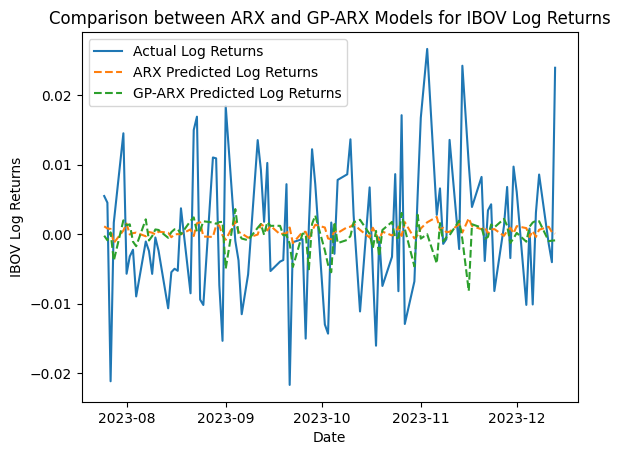

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.linear_model import LinearRegression
from datetime import datetime

# Baixe os dados do IBOV usando a biblioteca yfinance
start_date = '2022-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')
ibov_data = yf.download('^BVSP', start=start_date, end=end_date)['Adj Close']

# Calcular os log retornos
ibov_log_returns = np.log(ibov_data / ibov_data.shift(1)).dropna()

# Criar um dataframe com lags dos log retornos do IBOV como variável exógena
data = pd.DataFrame({'IBOV_Log_Returns': ibov_log_returns, 'IBOV_Log_Returns_Lag1': ibov_log_returns.shift(1)})

# Remover NaNs resultantes dos lags
data = data.dropna()

# Dividir os dados em treinamento e teste
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Definir as variáveis dependentes e independentes
y_train, X_train = train['IBOV_Log_Returns'], train[['IBOV_Log_Returns_Lag1']]
y_test, X_test = test['IBOV_Log_Returns'], test[['IBOV_Log_Returns_Lag1']]

# Ajustar o modelo ARX
arx_model = LinearRegression()
arx_model.fit(X_train, y_train)
log_returns_predictions_arx = arx_model.predict(X_test)

# Ajustar o modelo de processo gaussiano aos resíduos
residuals = y_train - arx_model.predict(X_train)
residuals = residuals.values.reshape(-1, 1)  # Reshape para um array 2D
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp_model.fit(X_train, residuals)

# Prever os resíduos nos dados de teste
residuals_pred, _ = gp_model.predict(X_test, return_std=True)

# Adicionar a previsão dos resíduos aos resultados do ARX
log_returns_predictions_gparx = arx_model.predict(X_test) + residuals_pred.flatten()

# Avaliar o desempenho dos modelos (pode ser adaptado conforme necessário)
mse_arx = np.mean((log_returns_predictions_arx - y_test)**2)
mse_gparx = np.mean((log_returns_predictions_gparx - y_test)**2)

print(f'Mean Squared Error (MSE) - ARX: {mse_arx}')
print(f'Mean Squared Error (MSE) - GP-ARX: {mse_gparx}')

# Visualizar os resultados
import matplotlib.pyplot as plt

plt.plot(test.index, y_test, label='Actual Log Returns')
plt.plot(test.index, log_returns_predictions_arx, label='ARX Predicted Log Returns', linestyle='--')
plt.plot(test.index, log_returns_predictions_gparx, label='GP-ARX Predicted Log Returns', linestyle='--')
plt.legend()
plt.xlabel('Date')
plt.ylabel('IBOV Log Returns')
plt.title('Comparison between ARX and GP-ARX Models for IBOV Log Returns')
plt.show()


2023-12-14 22:46:56.651371: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-14 22:46:57.340586: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-14 22:46:57.341005: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-14 22:46:57.472801: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-14 22:46:57.784097: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-14 22:46:57.788355: I tensorflow/core/platform/cpu_feature_guard.cc:1

[*********************100%%**********************]  1 of 1 completed
Epoch 1/50
6/6 - 1s - loss: 0.0585 - 1s/epoch - 219ms/step
Epoch 2/50
6/6 - 0s - loss: 0.0338 - 23ms/epoch - 4ms/step
Epoch 3/50
6/6 - 0s - loss: 0.0198 - 24ms/epoch - 4ms/step
Epoch 4/50
6/6 - 0s - loss: 0.0166 - 22ms/epoch - 4ms/step
Epoch 5/50
6/6 - 0s - loss: 0.0148 - 23ms/epoch - 4ms/step
Epoch 6/50
6/6 - 0s - loss: 0.0127 - 23ms/epoch - 4ms/step
Epoch 7/50
6/6 - 0s - loss: 0.0107 - 23ms/epoch - 4ms/step
Epoch 8/50
6/6 - 0s - loss: 0.0104 - 26ms/epoch - 4ms/step
Epoch 9/50
6/6 - 0s - loss: 0.0099 - 28ms/epoch - 5ms/step
Epoch 10/50
6/6 - 0s - loss: 0.0090 - 25ms/epoch - 4ms/step
Epoch 11/50
6/6 - 0s - loss: 0.0085 - 27ms/epoch - 4ms/step
Epoch 12/50
6/6 - 0s - loss: 0.0077 - 30ms/epoch - 5ms/step
Epoch 13/50
6/6 - 0s - loss: 0.0074 - 27ms/epoch - 4ms/step
Epoch 14/50
6/6 - 0s - loss: 0.0071 - 28ms/epoch - 5ms/step
Epoch 15/50
6/6 - 0s - loss: 0.0070 - 26ms/epoch - 4ms/step
Epoch 16/50
6/6 - 0s - loss: 0.0068 - 25

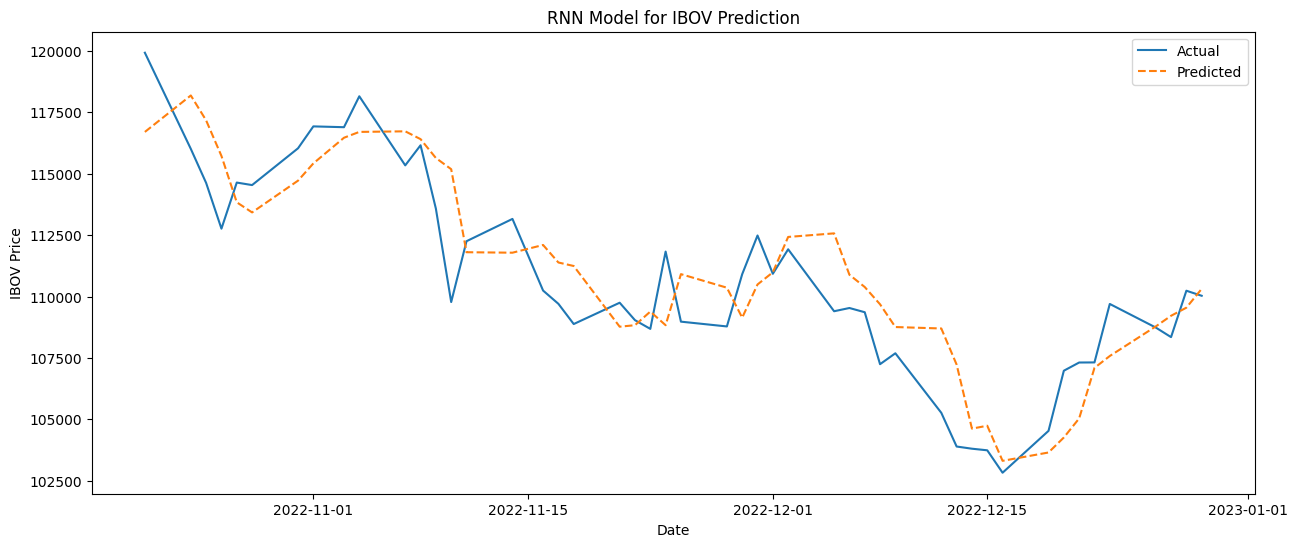

In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt

# Baixe os dados do IBOV usando a biblioteca yfinance
start_date = '2022-01-01'
end_date = '2023-01-01'
ibov_data = yf.download('^BVSP', start=start_date, end=end_date)['Adj Close']

# Remover NaNs resultantes dos lags
ibov_data = ibov_data.dropna()

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
ibov_data_normalized = scaler.fit_transform(np.array(ibov_data).reshape(-1, 1))

# Função para criar sequências temporais para treinamento da RNN
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Escolher o comprimento da sequência
sequence_length = 10

# Criar sequências temporais e alvos
X, y = create_sequences(ibov_data_normalized, sequence_length)

# Dividir os dados em conjuntos de treinamento e teste
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Construir o modelo RNN
model = Sequential()
model.add(SimpleRNN(50, input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

# Fazer previsões nos dados de teste
predictions = model.predict(X_test)

# Desnormalizar as previsões e os dados de teste
predictions_denormalized = scaler.inverse_transform(predictions)
y_test_denormalized = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calcular o erro médio quadrático
mse = mean_squared_error(y_test_denormalized, predictions_denormalized)
print(f'Mean Squared Error (MSE): {mse}')

# Visualizar os resultados
plt.figure(figsize=(15, 6))
plt.plot(ibov_data.index[train_size + sequence_length:], y_test_denormalized, label='Actual')
plt.plot(ibov_data.index[train_size + sequence_length:], predictions_denormalized, label='Predicted', linestyle='--')
plt.legend()
plt.xlabel('Date')
plt.ylabel('IBOV Price')
plt.title('RNN Model for IBOV Prediction')
plt.show()


[*********************100%%**********************]  1 of 1 completed


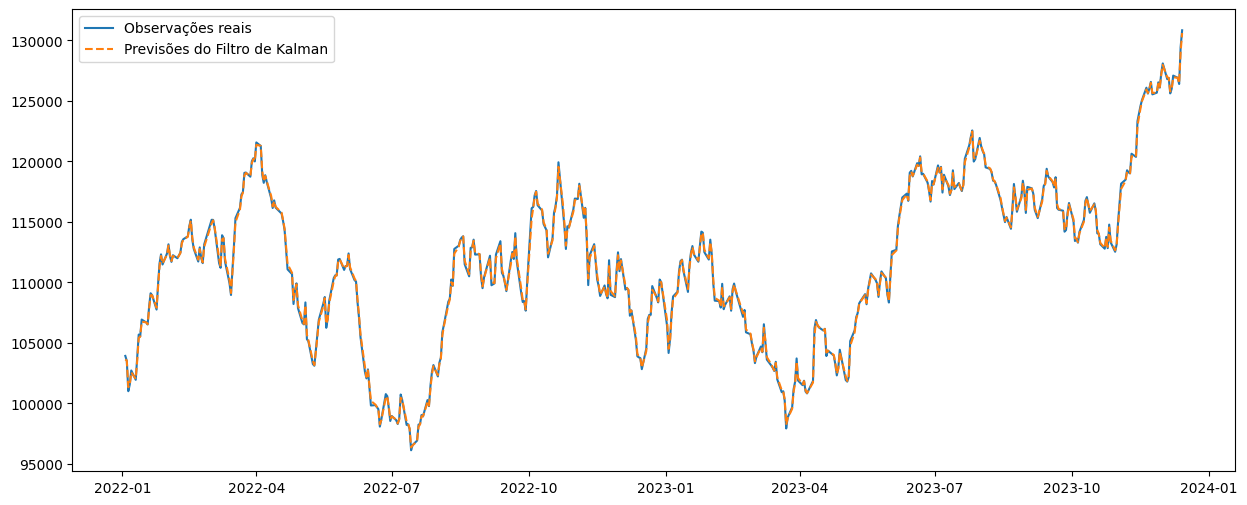

In [7]:
import numpy as np
from pykalman import KalmanFilter
import pandas as pd
import matplotlib.pyplot as plt

# Carregue seus dados do IBOV aqui (pode usar bibliotecas como pandas para isso)
# Exemplo fictício:
# ibov_data = pd.read_csv('caminho_para_dados_ibov.csv')

# Substitua o seguinte trecho pelo seu conjunto de dados

start_date = '2022-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')
ibov_data = yf.download('^BVSP', start=start_date, end=end_date)['Adj Close']
#ibov_data = np.random.rand(100) * 10 + np.sin(np.linspace(0, 4 * np.pi, 100)) * 10

kf = KalmanFilter(initial_state_mean=ibov_data[0], n_dim_obs=1)

# Ajuste o modelo
kf = kf.em(ibov_data, n_iter=10)

# Previsão
(filtered_state_means, _) = kf.filter(ibov_data)

# Plote os resultados
plt.figure(figsize=(15, 6))
plt.plot(ibov_data, label='Observações reais')
plt.plot(ibov_data.index,filtered_state_means, label='Previsões do Filtro de Kalman', linestyle='dashed')
plt.legend()
plt.show()


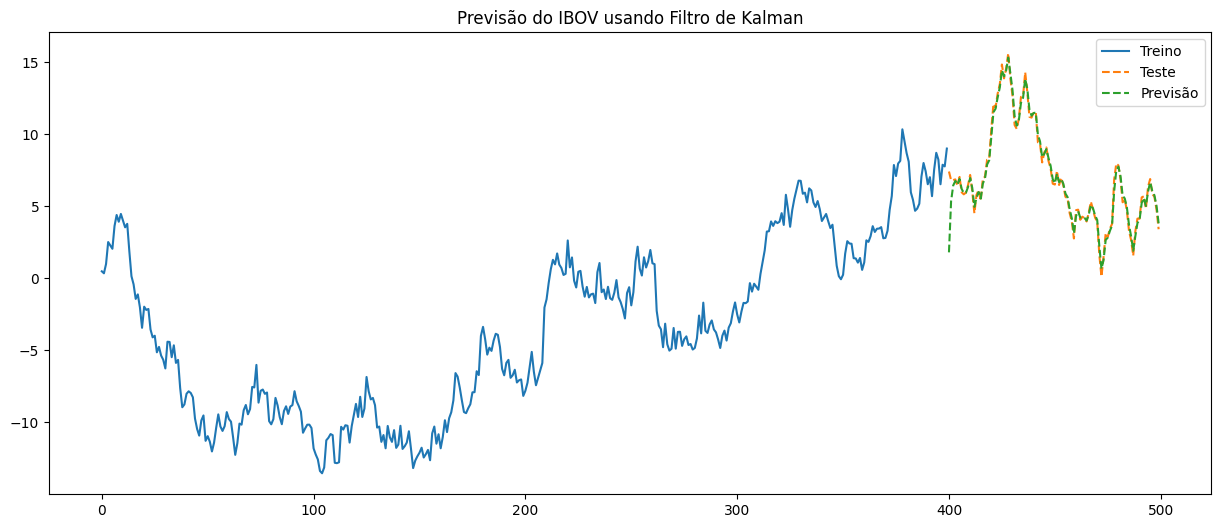

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# Supondo que você já tenha uma Series chamada ibov_data
# Exemplo fictício:
# ibov_data = pd.read_csv('caminho_para_dados_ibov.csv')['Close']

# Gere um exemplo fictício de dados
np.random.seed(42)
ibov_data = pd.Series(np.cumsum(np.random.randn(500)), name='IBOV')

# Divida os dados em treino e teste
train_size = int(len(ibov_data) * 0.8)
train_data, test_data = ibov_data[:train_size], ibov_data[train_size:]

# Converta os dados em arrays numpy
train_data_array = train_data.values.reshape(-1, 1)
test_data_array = test_data.values.reshape(-1, 1)

# Ajuste do Filtro de Kalman com menos iterações
kf = KalmanFilter(initial_state_mean=train_data_array[0], n_dim_obs=1)
kf = kf.em(train_data_array, n_iter=5)

# Faça a previsão para os dados de teste
(filtered_state_means_test, _) = kf.filter(test_data_array)

# Plot dos resultados
plt.figure(figsize=(15, 6))
plt.plot(train_data, label='Treino')
plt.plot(test_data, label='Teste', linestyle='dashed')
plt.plot(range(train_size, len(ibov_data)), filtered_state_means_test, label='Previsão', linestyle='dashed')
plt.legend()
plt.title('Previsão do IBOV usando Filtro de Kalman')
plt.show()


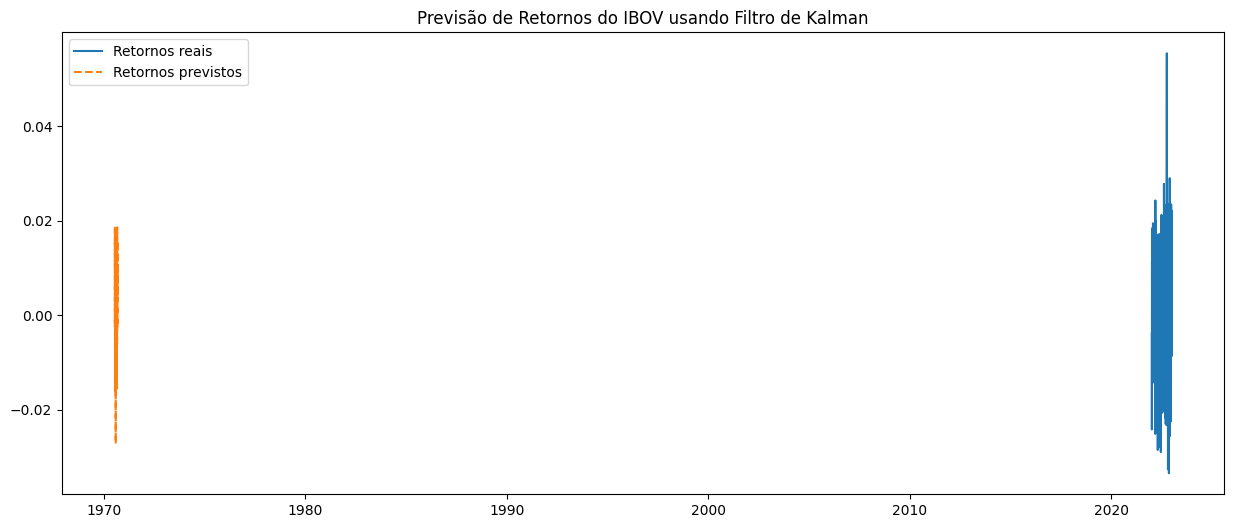

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# Supondo que você já tenha uma Series chamada ibov_data
# Exemplo fictício:
# ibov_data = pd.read_csv('caminho_para_dados_ibov.csv')['Close']

# Gere um exemplo fictício de dados

# Calcula os retornos a partir dos preços de fechamento
returns = ibov_data.pct_change().dropna()

# Divida os dados em treino e teste
train_size = int(len(returns) * 0.8)
train_data, test_data = returns[:train_size], returns[train_size:]

# Converta os dados em arrays numpy
train_data_array = train_data.values.reshape(-1, 1)
test_data_array = test_data.values.reshape(-1, 1)

# Ajuste do Filtro de Kalman com menos iterações
kf = KalmanFilter(initial_state_mean=train_data_array[0], n_dim_obs=1)
kf = kf.em(train_data_array, n_iter=5)

# Faça a previsão para os dados de teste
(filtered_state_means_test, _) = kf.filter(test_data_array)

# Calcula os retornos previstos
predicted_returns = np.concatenate([[train_data_array[-1]], filtered_state_means_test[:-1]])

# Calcula os preços previstos a partir dos retornos
predicted_prices = np.cumsum(predicted_returns)

# Plot dos resultados
plt.figure(figsize=(15, 6))
plt.plot(returns, label='Retornos reais')
plt.plot(range(train_size, len(returns)), predicted_returns, label='Retornos previstos', linestyle='dashed')
plt.legend()
plt.title('Previsão de Retornos do IBOV usando Filtro de Kalman')
plt.show()
